In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

%matplotlib inline

In [4]:
df = pd.read_excel('nsrdb_data.xlsx')

df.head()

,Year,Month,Day,Hour,Minute,DHI,Clearsky DNI,GHI,Solar Zenith Angle,Clearsky GHI,Temperature,DNI,Ozone,Clearsky DHI,Cloud Type
0,2022,1,1,0,0,0,0,0,92.68,0,-10.9,0,0.271,0,8
1,2022,1,1,0,30,0,0,0,97.90,0,-11.7,0,0.271,0,8
2,2022,1,1,1,0,0,0,0,103.29,0,-12.6,0,0.271,0,7
3,2022,1,1,1,30,0,0,0,108.83,0,-13.3,0,0.271,0,7
4,2022,1,1,2,0,0,0,0,114.48,0,-14.1,0,0.271,0,8


# Introduction

#### For this time series analysis, I will use the SARIMAX framework from the statsmodel API to create this forecasting model. This model will forecast Global Horizontal Irradiance (GHI) using data from the National Solar Radiation Database (NSRDB). The data will also be regressed on temperature and solar zenith angle to measure the impact that these variables have on GHI. Below are some initial visualizations of my data.

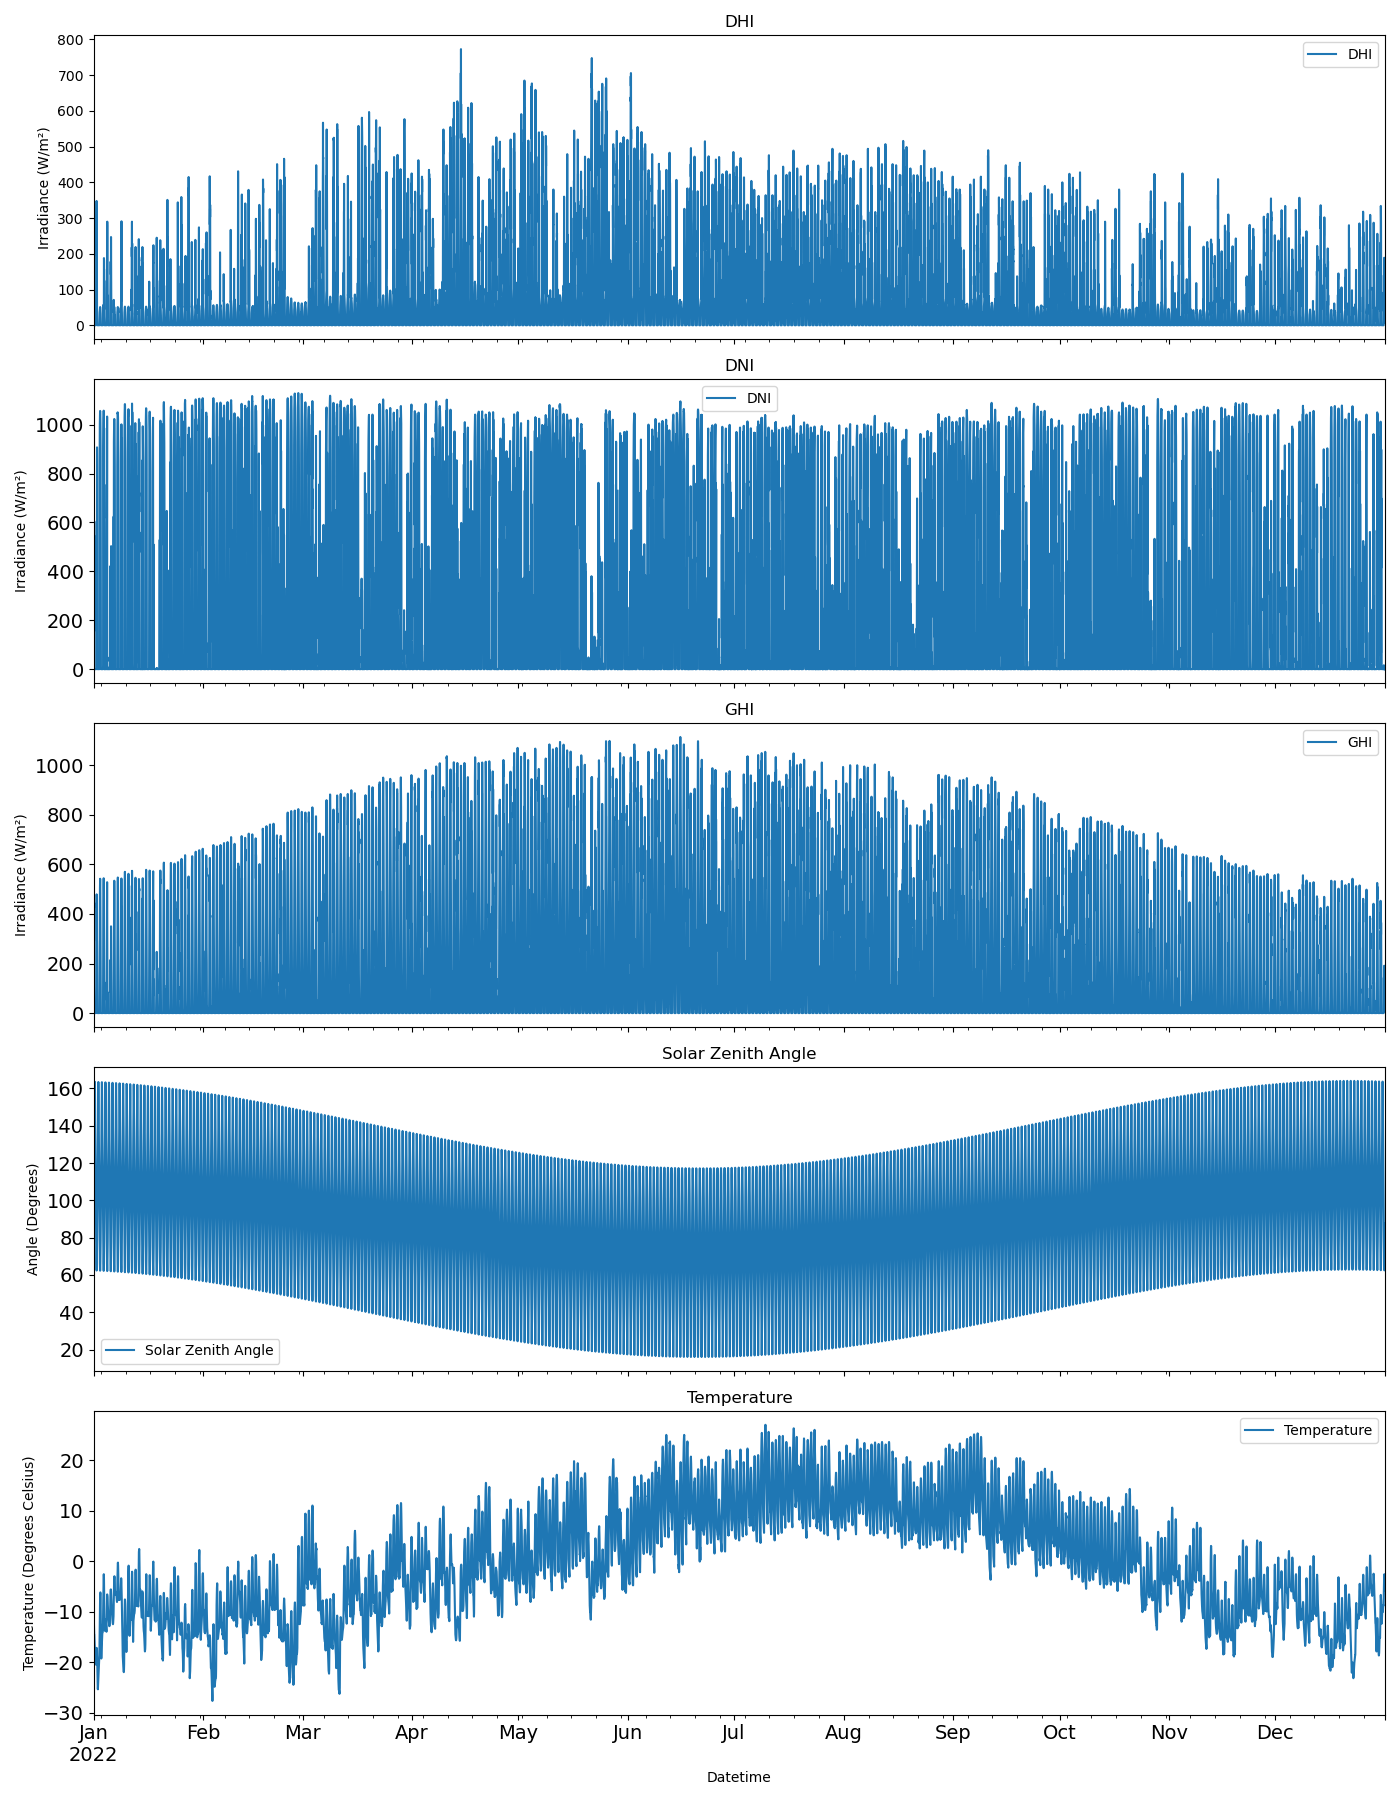

#### Note that Direct Normal Irradiance (DNI) and Diffuse Horizontal Irradiance (DHI) were included in these visualizations. They will not be forecasted or regressed on. However, they are relevant to visualize, as GHI is a composite measure of DNI and DHI. Specifically, GHI is measured as 

#### $$ \begin{aligned} GHI = DHI + DNI * cos(\theta) \end{aligned}$$

#### where $cos(\theta)$ is the solar zenith angle.

# Model Creation

#### From here, we will use the data, as well as the analysis above to create our SARIMA model for analysis.

In [5]:
endogenous = df['GHI']
exogenous = df[['Temperature', 'Solar Zenith Angle']]

# Splitting the data into training and testing sets
exogenous_train, exogenous_test, endogenous_train, endogenous_test = train_test_split(exogenous, endogenous, train_size=.8, shuffle=False)

exogenous_train.shape, exogenous_test.shape, endogenous_train.shape, endogenous_test.shape

((14016, 2), (3504, 2), (14016,), (3504,))

# Augmented Dickey Fuller Test

#### This test will help us determine whether there is stationarity in our time-series data by testing to see if a unit root is present in the data. If it is, this means the null hypothesis is true, which suggests non-stationarity in the data. 

#### The critical value of the test is -7.15. The T-values at the 1%, 5%, and 10% confidence intervals are -3.43, -2.86, and -2.57, respectively. Since the critical values is less than all of the T-values, we can conclude with certainty that the data is stationary.

In [6]:
from statsmodels.tsa.stattools import adfuller
adf= adfuller(endogenous)

print(adf)

(-7.148084377820789, 3.1937219862599436e-10, 44, 17475, {'1%': -3.4307242638530675, '5%': -2.861705410152796, '10%': -2.5668580435332715}, 207065.97254520986)


# ACF and PACF

#### Here we will examine the ACF and PACF to examine relationships between observed data and their lags. We will use these interpretations to tune the nons-seasonal parameters (p,d,q) and seasonal parameters (P,D,Q,S) in our SARIMA model.

#### The ACF appears to have no significant spikes, but rather follows a sinusoidal-like pattern. However, we see significant spikes in the PACF plot on lags 1 and 2. Since there is a spike, we can set fix p=2 for our model parameters. 

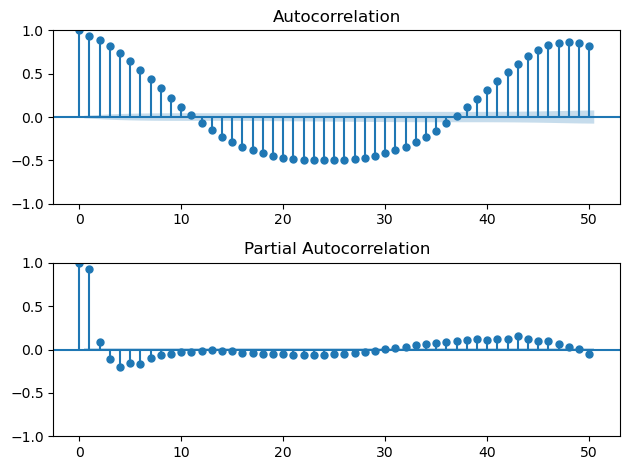

In [7]:
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(endogenous, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(endogenous, lags=50, ax=ax[1])

plt.tight_layout()
plt.savefig('acf_pacf.png')
plt.show()


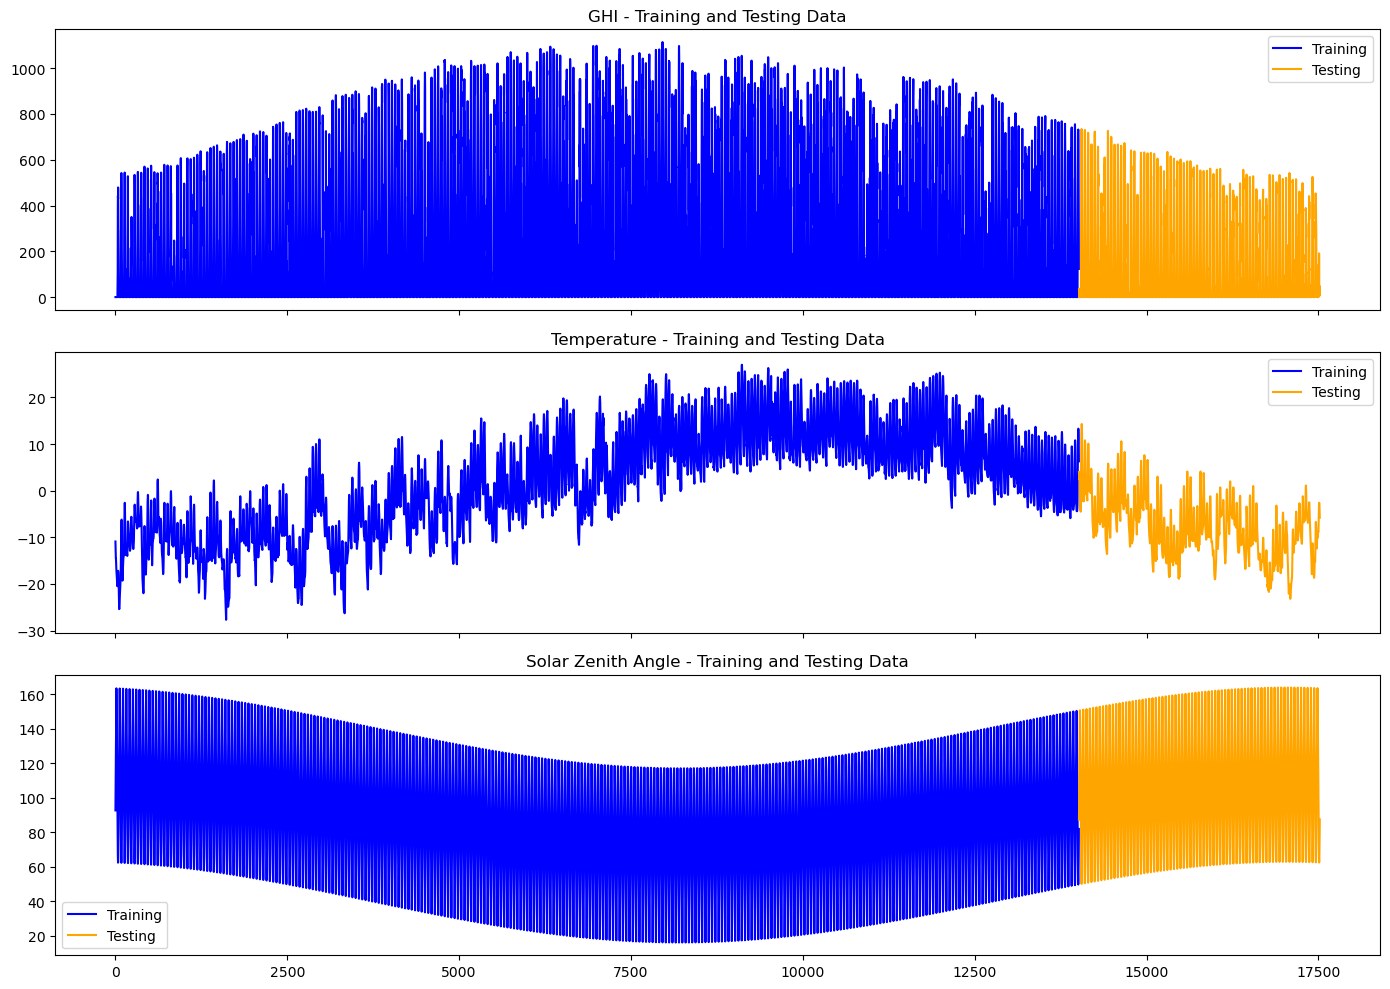

In [8]:
# Visualization of training and testing data

df['Datetime'] = pd.to_datetime(df[['Year','Month', 'Day', 'Hour', 'Minute']])
df.set_index('Datetime', inplace=True)

fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# GHI
axs[0].plot(endogenous_train.index, endogenous_train, label='Training', color='blue')
axs[0].plot(endogenous_test.index, endogenous_test, label='Testing', color='orange')
axs[0].set_title('GHI - Training and Testing Data')
axs[0].legend()

# Temperature
axs[1].plot(exogenous_train.index, exogenous_train['Temperature'], label='Training', color='blue')
axs[1].plot(exogenous_test.index, exogenous_test['Temperature'], label='Testing', color='orange')
axs[1].set_title('Temperature - Training and Testing Data')
axs[1].legend()

# Solar Zenith Angle
axs[2].plot(exogenous_train.index, exogenous_train['Solar Zenith Angle'], label='Training', color='blue')
axs[2].plot(exogenous_test.index, exogenous_test['Solar Zenith Angle'], label='Testing', color='orange')
axs[2].set_title('Solar Zenith Angle - Training and Testing Data')
axs[2].legend()

plt.tight_layout()
fig.savefig('train_test_data.png')
plt.show()


In [9]:
#Training model
model = SARIMAX(endogenous_train, exogenous_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 8))
results = model.fit()

print(results.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.48722D+00    |proj g|=  1.08534D+00

At iterate    5    f=  6.12122D+00    |proj g|=  1.03709D-02

At iterate   10    f=  6.11440D+00    |proj g|=  4.39347D-02

At iterate   15    f=  6.08752D+00    |proj g|=  7.26809D-03

At iterate   20    f=  6.08295D+00    |proj g|=  2.96843D-02

At iterate   25    f=  6.07633D+00    |proj g|=  5.43358D-03

At iterate   30    f=  6.06809D+00    |proj g|=  1.92239D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  6.06761D+00    |proj g|=  8.69605D-04

At iterate   40    f=  6.06747D+00    |proj g|=  5.97796D-04

At iterate   45    f=  6.06685D+00    |proj g|=  1.00081D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     84      2     0     0   4.112D-04   6.067D+00
  F =   6.0667863093814942     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                     
Dep. Variable:                               GHI   No. Observations:                14016
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 8)   Log Li

# Results 

#### Above are the results of the SARIMAX model with the orders (1,0,1)x(1,0,1,8). Note that we use S=8. I would have liked to use S=48, as the data follows a daily seasonality trend (because the sun sets and rises every day), but my Mac almost had a heart attack trying to run the regression with those parameters. Instead, I made the model parameters to follow a quarterly seasonality to capture the change in calendar seasons.

#### From the regression, we get coefficient values of 15.08 for Temperature and 0.94 for Solar Zenith Angle, implying that per a unit increase in temperature and solar zenith angle, we expect a 15.08 and 0.94 respective unit increase for GHI, on average. The temperature regressor has a z-score of 67.55 and a 0 p-score. Similarly, solar zenith angle has a z-score of 14.22 and a p-value of 0. This implies that both of these exogenous regressors have significant impact on GHI, as hypothesized.

#### There are significant caveats of the model performance summary that afflict the validity of the model. The $\sigma^2$ value was quite high at 1093, indicating a high amount of variance in the data that the model is not picking up, also with a std error of 51.960.

#### For the diagnostic statistics, we get a Prob(Q) value of .98, suggesting a very high probability of no autocorrelation in the data, which is good because this means that the distribution of residuals is most likely random and that the model does not miss out on trends in the data. We also get a Prob(JB) score of 0, which suggests that the data is most likely not normally distributed. However, this test becomes more sensitive as datasets become larger.

# Prediction and Error Analysis

#### The following cells will examine the model's prediction performance.

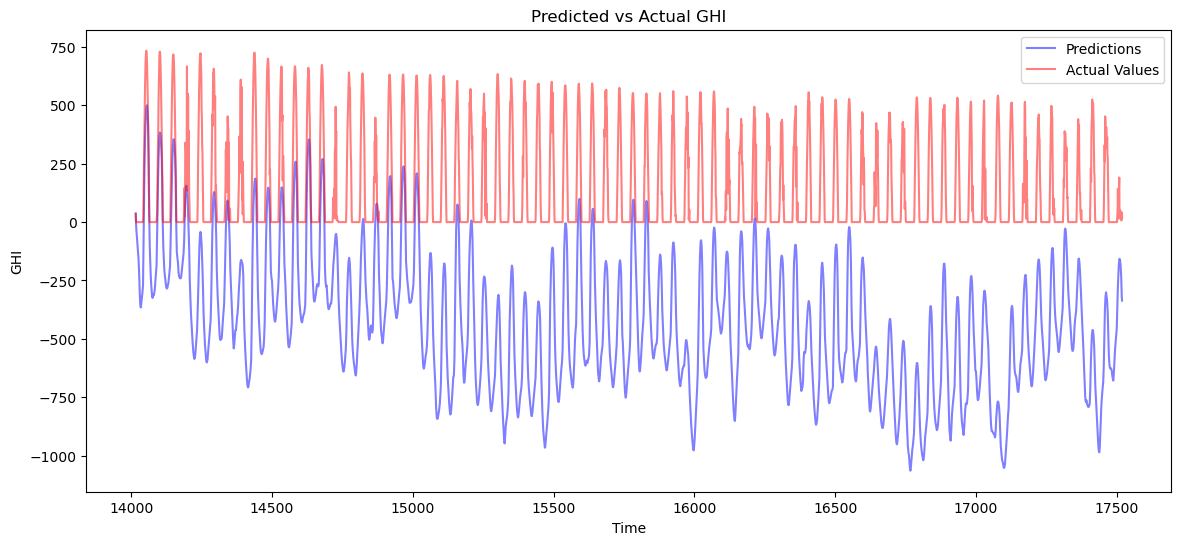

In [23]:
start = exogenous_test.index[0]
end = exogenous_test.index[-1]
predictions = results.predict(start=start, end=end, exog=exogenous_test)
predictions.index = exogenous_test.index

plt.figure(figsize=(14,6))
plt.plot(predictions.index, predictions, color='blue', label='Predictions', alpha=0.5)
plt.plot(endogenous_test.index, endogenous_test, color='red', label='Actual Values', alpha=0.5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('GHI')
plt.title('Predicted vs Actual GHI')
plt.savefig('predicted_vs_actual_GHI.png')
plt.show()



In [16]:
mapes = []

def mse(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))


# Filter out pairs where the true value is zero (to avoid division by zero)
mask = endogenous_test != 0
filtered_predictions = predictions[mask]
filtered_true_values = endogenous_test[mask]

rmse = rmse(filtered_true_values, filtered_predictions)
mse = mse(filtered_true_values, filtered_predictions)

print("RMSE:", rmse)
print("MSE:", mse)



RMSE: 573.3778718183734
MSE: 328762.18389096693


# Error Insights

#### As can be seen by the graph and the error statistics, the model performance was subpar, if that. The model follows an opposite trend than the actual values, as we can see the trend divergence in the graph. Additionally, we get MSE and RMSE values of 59446.87 and 243.82 respectively, suggesting that there is a high amount of expected error between predictions and actual values. These obviously indicate that the model does not perform well and needs much more tuning.

# Future Work

#### Though the model follows the right track, it still needs a great deal of improvement to be a viable model. Firstly, the model could use some parameter order tuning. These ARIMA and SARIMA and ARMA models require precise accurate tuning, so more analysis and testing is required for tuning. Additionally, more computing power is needed to run SARIMA models with large S parametersm, as it is extremly expensive to run. Other aspects that can be included in the model are other aspects of the data. I only used solar zenith angle and temperature as regressors to keep the model simple. However, there are other aspects of the data that can help capture the trend of the data better, including atmospheric ozone levels, cloud type and density, and humidity. Additionally, we can explore other questions related to this forecast that may help us understand the data trends better. For example, we may ask "what cloud type will yield the highest GHI on average, and which will yield the lowest on average?". We can use some classification algorithms to determine these types of questions for further use in predictive analyses.